# Training

Test different pipeline primarily using the linear model response to feature engineering efforts.

In [238]:

import logging
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src import utils
from src.modelling import transforms
from src.modelling import training
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
experiments = {}
model_names = ['linear_model', 'xgboost']
n_tuning_trials = 3
test_size = 0.01

## Baseline

In [240]:
experiment_name = 'baseline'
proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')

def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])

    

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results


[I 2024-04-05 19:37:05,480] A new study created in memory with name: no-name-7328d057-e764-43a4-a121-6ef3a14e2f0d


[I 2024-04-05 19:37:05,963] Trial 0 finished with value: -0.22662866168678772 and parameters: {'alpha': 3.387013560007059}. Best is trial 0 with value: -0.22662866168678772.


Trial 0, alpha: 3.387013560007059,  mape: 0.22662866168678772


[I 2024-04-05 19:37:06,475] Trial 1 finished with value: -0.2274553071534931 and parameters: {'alpha': 0.7759264553271104}. Best is trial 0 with value: -0.22662866168678772.


Trial 1, alpha: 0.7759264553271104,  mape: 0.2274553071534931


[I 2024-04-05 19:37:07,013] Trial 2 finished with value: -0.227618033440544 and parameters: {'alpha': 0.27998092176597084}. Best is trial 0 with value: -0.22662866168678772.


Trial 2, alpha: 0.27998092176597084,  mape: 0.227618033440544
best score is: -0.22662866168678772
test score:0.10977453805338153
test score:0.10977453805338153


[I 2024-04-05 19:37:07,364] A new study created in memory with name: no-name-89bf6660-a44f-48ba-b311-a3de14a13c6f
[I 2024-04-05 19:37:09,859] Trial 0 finished with value: -0.09415059840217961 and parameters: {'n_estimators': 11, 'max_depth': 10, 'learning_rate': 0.20594807881043456, 'min_child_weight': 10, 'subsample': 0.6090957590518646, 'gamma': 0.7762741797172545, 'reg_alpha': 0.9062556940311429, 'reg_lambda': 0.6952507986953744}. Best is trial 0 with value: -0.09415059840217961.


Trial 0, n_estimators: 11, max_depth: 10, learning_rate: 0.20594807881043456,min_child_weight: 10, subsample: 0.6090957590518646 gamma: 0.7762741797172545, reg_alpha: 0.9062556940311429, reg_lambda: 0.6952507986953744, mape: 0.09415059840217961


[I 2024-04-05 19:37:13,264] Trial 1 finished with value: -0.09829489545857549 and parameters: {'n_estimators': 43, 'max_depth': 4, 'learning_rate': 0.11466376121940418, 'min_child_weight': 2, 'subsample': 0.5409071479150733, 'gamma': 0.9816640717021414, 'reg_alpha': 0.21481642776936882, 'reg_lambda': 0.43815634221820776}. Best is trial 0 with value: -0.09415059840217961.


Trial 1, n_estimators: 43, max_depth: 4, learning_rate: 0.11466376121940418,min_child_weight: 2, subsample: 0.5409071479150733 gamma: 0.9816640717021414, reg_alpha: 0.21481642776936882, reg_lambda: 0.43815634221820776, mape: 0.09829489545857549


[I 2024-04-05 19:37:16,474] Trial 2 finished with value: -0.08696585746898328 and parameters: {'n_estimators': 5, 'max_depth': 46, 'learning_rate': 0.3983190393947633, 'min_child_weight': 2, 'subsample': 0.7299538344283512, 'gamma': 0.7323385142877932, 'reg_alpha': 0.6458395383044375, 'reg_lambda': 0.6301146037529622}. Best is trial 2 with value: -0.08696585746898328.


Trial 2, n_estimators: 5, max_depth: 46, learning_rate: 0.3983190393947633,min_child_weight: 2, subsample: 0.7299538344283512 gamma: 0.7323385142877932, reg_alpha: 0.6458395383044375, reg_lambda: 0.6301146037529622, mape: 0.08696585746898328
best score is: -0.08696585746898328
test score:0.09173061820392486
test score:0.09173061820392486


## Add higer order temperature

In [241]:

experiment_name = 'higher_order_temperature'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)



    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-04-05 19:37:17,031] A new study created in memory with name: no-name-e70c59cc-2a6a-46ae-8534-c43f23671728


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:37:17,793] Trial 0 finished with value: -0.09519655126102895 and parameters: {'alpha': 2.1340199136485376}. Best is trial 0 with value: -0.09519655126102895.


Trial 0, alpha: 2.1340199136485376,  mape: 0.09519655126102895


[I 2024-04-05 19:37:18,543] Trial 1 finished with value: -0.09520279700259501 and parameters: {'alpha': 0.44111856067085503}. Best is trial 0 with value: -0.09519655126102895.


Trial 1, alpha: 0.44111856067085503,  mape: 0.09520279700259501


[I 2024-04-05 19:37:19,045] Trial 2 finished with value: -0.0952013589563154 and parameters: {'alpha': 0.6655639160245281}. Best is trial 0 with value: -0.09519655126102895.


Trial 2, alpha: 0.6655639160245281,  mape: 0.0952013589563154
best score is: -0.09519655126102895
test score:0.0849260556526917
test score:0.0849260556526917
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:37:19,326] A new study created in memory with name: no-name-9fe88358-e67c-40f6-ba39-6ddfd044f085
[I 2024-04-05 19:37:23,150] Trial 0 finished with value: -0.0839568539275999 and parameters: {'n_estimators': 138, 'max_depth': 16, 'learning_rate': 0.3220817282064455, 'min_child_weight': 7, 'subsample': 0.6553778610334406, 'gamma': 0.9076072619556702, 'reg_alpha': 0.9519430719286663, 'reg_lambda': 0.03935942299438533}. Best is trial 0 with value: -0.0839568539275999.


Trial 0, n_estimators: 138, max_depth: 16, learning_rate: 0.3220817282064455,min_child_weight: 7, subsample: 0.6553778610334406 gamma: 0.9076072619556702, reg_alpha: 0.9519430719286663, reg_lambda: 0.03935942299438533, mape: 0.0839568539275999


[I 2024-04-05 19:37:23,818] Trial 1 finished with value: -0.22598988807396517 and parameters: {'n_estimators': 3, 'max_depth': 35, 'learning_rate': 0.05641909153020814, 'min_child_weight': 5, 'subsample': 0.9811765262481735, 'gamma': 0.16930966992603025, 'reg_alpha': 0.019099509708773166, 'reg_lambda': 0.3186344358984695}. Best is trial 0 with value: -0.0839568539275999.


Trial 1, n_estimators: 3, max_depth: 35, learning_rate: 0.05641909153020814,min_child_weight: 5, subsample: 0.9811765262481735 gamma: 0.16930966992603025, reg_alpha: 0.019099509708773166, reg_lambda: 0.3186344358984695, mape: 0.22598988807396517


[I 2024-04-05 19:37:28,155] Trial 2 finished with value: -0.09664713001203072 and parameters: {'n_estimators': 37, 'max_depth': 33, 'learning_rate': 0.039394431607674946, 'min_child_weight': 5, 'subsample': 0.9360295767205428, 'gamma': 0.9098919200480139, 'reg_alpha': 0.2798903019280473, 'reg_lambda': 0.3692297265382214}. Best is trial 0 with value: -0.0839568539275999.


Trial 2, n_estimators: 37, max_depth: 33, learning_rate: 0.039394431607674946,min_child_weight: 5, subsample: 0.9360295767205428 gamma: 0.9098919200480139, reg_alpha: 0.2798903019280473, reg_lambda: 0.3692297265382214, mape: 0.09664713001203072
best score is: -0.0839568539275999
test score:0.08551367701664296
test score:0.08551367701664296


## Create interactions

In [242]:

experiment_name = 'model interactions'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)

    daily_load_profile_path = proj_root.joinpath(
        config["modelling_paths"]["daily_load_profile_feature"]
    )


    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

            (
                "create_interaction_temp_hour_profile_2", transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "hour"],
                    new_column_name="temp_hour_p2",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_temp_month",
                transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "month"],
                    new_column_name="temp_month",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_month_hour",
                transforms.MultiColumnTransformer(
                    column_names=["month", "hour"],
                    new_column_name="month_hour",
                    derive_func=transforms.multiply_columns,
                ),
            ),

                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-04-05 19:37:30,362] A new study created in memory with name: no-name-d9b19890-5c45-4c00-9474-acd1cffed0dd


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:37:31,020] Trial 0 finished with value: -0.10382413136050464 and parameters: {'alpha': 3.3673421740035203}. Best is trial 0 with value: -0.10382413136050464.


Trial 0, alpha: 3.3673421740035203,  mape: 0.10382413136050464


[I 2024-04-05 19:37:31,676] Trial 1 finished with value: -0.1037631156960676 and parameters: {'alpha': 0.17963340332340755}. Best is trial 1 with value: -0.1037631156960676.


Trial 1, alpha: 0.17963340332340755,  mape: 0.1037631156960676


[I 2024-04-05 19:37:32,489] Trial 2 finished with value: -0.10377434097642671 and parameters: {'alpha': 0.36890125898717574}. Best is trial 1 with value: -0.1037631156960676.


Trial 2, alpha: 0.36890125898717574,  mape: 0.10377434097642671
best score is: -0.1037631156960676
test score:0.08240071585859729
test score:0.08240071585859729
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:37:32,989] A new study created in memory with name: no-name-0dbb5270-e942-49bd-a451-35480cd05893
[I 2024-04-05 19:37:35,992] Trial 0 finished with value: -0.10617678466840146 and parameters: {'n_estimators': 56, 'max_depth': 17, 'learning_rate': 0.7632986065701697, 'min_child_weight': 7, 'subsample': 0.9894714231088741, 'gamma': 0.7736773907207938, 'reg_alpha': 0.9679063995973319, 'reg_lambda': 0.5632699550331086}. Best is trial 0 with value: -0.10617678466840146.


Trial 0, n_estimators: 56, max_depth: 17, learning_rate: 0.7632986065701697,min_child_weight: 7, subsample: 0.9894714231088741 gamma: 0.7736773907207938, reg_alpha: 0.9679063995973319, reg_lambda: 0.5632699550331086, mape: 0.10617678466840146


[I 2024-04-05 19:37:41,799] Trial 1 finished with value: -0.09987103305561305 and parameters: {'n_estimators': 61, 'max_depth': 37, 'learning_rate': 0.35081691224013206, 'min_child_weight': 9, 'subsample': 0.8315958602633053, 'gamma': 0.36684962862665105, 'reg_alpha': 0.4463059156021689, 'reg_lambda': 0.9202273552947438}. Best is trial 1 with value: -0.09987103305561305.


Trial 1, n_estimators: 61, max_depth: 37, learning_rate: 0.35081691224013206,min_child_weight: 9, subsample: 0.8315958602633053 gamma: 0.36684962862665105, reg_alpha: 0.4463059156021689, reg_lambda: 0.9202273552947438, mape: 0.09987103305561305


[I 2024-04-05 19:37:43,952] Trial 2 finished with value: -0.10285339592947833 and parameters: {'n_estimators': 52, 'max_depth': 12, 'learning_rate': 0.46130646079356946, 'min_child_weight': 3, 'subsample': 0.7790431559285679, 'gamma': 0.9150414486020276, 'reg_alpha': 0.41087800322645485, 'reg_lambda': 0.6778000942546271}. Best is trial 1 with value: -0.09987103305561305.


Trial 2, n_estimators: 52, max_depth: 12, learning_rate: 0.46130646079356946,min_child_weight: 3, subsample: 0.7790431559285679 gamma: 0.9150414486020276, reg_alpha: 0.41087800322645485, reg_lambda: 0.6778000942546271, mape: 0.10285339592947833
best score is: -0.09987103305561305
test score:0.07955539693166333
test score:0.07955539693166333


## Engineer non-linear features

In [243]:

experiment_name = 'encode non-linearities'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)

    daily_load_profile_path = proj_root.joinpath(
        config["modelling_paths"]["daily_load_profile_feature"]
    )


    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

            (
                "create_interaction_temp_hour_profile_2", transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "hour"],
                    new_column_name="temp_hour_p2",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_temp_month",
                transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "month"],
                    new_column_name="temp_month",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_month_hour",
                transforms.MultiColumnTransformer(
                    column_names=["month", "hour"],
                    new_column_name="month_hour",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_non_linear_hour_features",
                transforms.HourlyProfileTransformer(
                    datetime_column_name="datetime",
                    feature_path=daily_load_profile_path,
                ),
            ),
            (
                "create_interaction_month_hour_profile_1",
                transforms.MultiColumnTransformer(
                    column_names=["month", "profile_1"],
                    new_column_name="month_hour_p1",
                    derive_func=transforms.multiply_columns,
                ),
            ),

                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-04-05 19:37:45,470] A new study created in memory with name: no-name-19a1ceb1-a6ab-4e80-9986-7b6878ff87b4


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:37:46,217] Trial 0 finished with value: -0.10235541585163661 and parameters: {'alpha': 0.1490087427562103}. Best is trial 0 with value: -0.10235541585163661.


Trial 0, alpha: 0.1490087427562103,  mape: 0.10235541585163661


[I 2024-04-05 19:37:46,880] Trial 1 finished with value: -0.10226901403405231 and parameters: {'alpha': 1.243175237514155}. Best is trial 1 with value: -0.10226901403405231.


Trial 1, alpha: 1.243175237514155,  mape: 0.10226901403405231


[I 2024-04-05 19:37:47,553] Trial 2 finished with value: -0.10229315715363077 and parameters: {'alpha': 0.9165525059211693}. Best is trial 1 with value: -0.10226901403405231.


Trial 2, alpha: 0.9165525059211693,  mape: 0.10229315715363077
best score is: -0.10226901403405231
test score:0.0811510998326014


[I 2024-04-05 19:37:47,902] A new study created in memory with name: no-name-9fb57104-1b50-4ff2-b3af-7f32792e79e6


test score:0.0811510998326014
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:37:48,996] Trial 0 finished with value: -0.08716956686316099 and parameters: {'n_estimators': 133, 'max_depth': 2, 'learning_rate': 0.4737419289461764, 'min_child_weight': 5, 'subsample': 0.8115910387294917, 'gamma': 0.0451595815781366, 'reg_alpha': 0.9003963706244554, 'reg_lambda': 0.8385663536800763}. Best is trial 0 with value: -0.08716956686316099.


Trial 0, n_estimators: 133, max_depth: 2, learning_rate: 0.4737419289461764,min_child_weight: 5, subsample: 0.8115910387294917 gamma: 0.0451595815781366, reg_alpha: 0.9003963706244554, reg_lambda: 0.8385663536800763, mape: 0.08716956686316099


[I 2024-04-05 19:37:54,382] Trial 1 finished with value: -0.2058472566626015 and parameters: {'n_estimators': 141, 'max_depth': 12, 'learning_rate': 0.0022440232750788455, 'min_child_weight': 9, 'subsample': 0.5452700989443104, 'gamma': 0.2255531320892069, 'reg_alpha': 0.4272310966348518, 'reg_lambda': 0.4850345139726663}. Best is trial 0 with value: -0.08716956686316099.


Trial 1, n_estimators: 141, max_depth: 12, learning_rate: 0.0022440232750788455,min_child_weight: 9, subsample: 0.5452700989443104 gamma: 0.2255531320892069, reg_alpha: 0.4272310966348518, reg_lambda: 0.4850345139726663, mape: 0.2058472566626015


[I 2024-04-05 19:38:22,911] Trial 2 finished with value: -0.09448804146132803 and parameters: {'n_estimators': 71, 'max_depth': 41, 'learning_rate': 0.04238754524195178, 'min_child_weight': 2, 'subsample': 0.978840806341158, 'gamma': 0.27671509192321675, 'reg_alpha': 0.270058861348333, 'reg_lambda': 0.24444151325376262}. Best is trial 0 with value: -0.08716956686316099.


Trial 2, n_estimators: 71, max_depth: 41, learning_rate: 0.04238754524195178,min_child_weight: 2, subsample: 0.978840806341158 gamma: 0.27671509192321675, reg_alpha: 0.270058861348333, reg_lambda: 0.24444151325376262, mape: 0.09448804146132803
best score is: -0.08716956686316099
test score:0.0788003214421578
test score:0.0788003214421578


## Add trend

In [244]:

experiment_name = 'add trend'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)

    daily_load_profile_path = proj_root.joinpath(
        config["modelling_paths"]["daily_load_profile_feature"]
    )


    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

            (
                "create_interaction_temp_hour_profile_2", transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "hour"],
                    new_column_name="temp_hour_p2",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_temp_month",
                transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "month"],
                    new_column_name="temp_month",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_month_hour",
                transforms.MultiColumnTransformer(
                    column_names=["month", "hour"],
                    new_column_name="month_hour",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_non_linear_hour_features",
                transforms.HourlyProfileTransformer(
                    datetime_column_name="datetime",
                    feature_path=daily_load_profile_path,
                ),
            ),
            (
                "create_interaction_month_hour_profile_1",
                transforms.MultiColumnTransformer(
                    column_names=["month", "profile_1"],
                    new_column_name="month_hour_p1",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_trend",
                transforms.DerivedColumnTransformer(
                    column_name="datetime",
                    new_column_name="trend",
                    derive_func=transforms.trend,
                ),
            ),
            # ("create_month_season",transforms.DerivedColumnTransformer(column_name='month', 
            #                                                 new_column_name='month_season', 
            #                                                 derive_func=transforms.season_encode)
            #                                                 ),
            # ("create_interaction_temp_month_season",transforms.MultiColumnTransformer(column_names=['mean_temp', 'month_season'], 
            #                                                 new_column_name='temp_month', 
            #                                                 derive_func=transforms.multiply_columns)
            #                                                 ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-04-05 19:38:23,526] A new study created in memory with name: no-name-68316cd9-f6ca-44b8-9207-8da5e3d2fd35


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:38:24,284] Trial 0 finished with value: -0.14665701302845685 and parameters: {'alpha': 0.7801984472462852}. Best is trial 0 with value: -0.14665701302845685.


Trial 0, alpha: 0.7801984472462852,  mape: 0.14665701302845685


[I 2024-04-05 19:38:25,173] Trial 1 finished with value: -0.14672500932161123 and parameters: {'alpha': 0.26249210768133036}. Best is trial 0 with value: -0.14665701302845685.


Trial 1, alpha: 0.26249210768133036,  mape: 0.14672500932161123


[I 2024-04-05 19:38:25,909] Trial 2 finished with value: -0.14672775131337257 and parameters: {'alpha': 0.24237014916040803}. Best is trial 0 with value: -0.14665701302845685.


Trial 2, alpha: 0.24237014916040803,  mape: 0.14672775131337257
best score is: -0.14665701302845685
test score:0.07296525472946994


[I 2024-04-05 19:38:26,254] A new study created in memory with name: no-name-b97f4b08-a269-4f1e-b039-94017a20e7b6


test score:0.07296525472946994
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 19:38:30,222] Trial 0 finished with value: -0.11100908571505139 and parameters: {'n_estimators': 104, 'max_depth': 16, 'learning_rate': 0.8781219054763405, 'min_child_weight': 9, 'subsample': 0.9778452359480247, 'gamma': 0.2513063795804411, 'reg_alpha': 0.22381655285625734, 'reg_lambda': 0.8165165695612057}. Best is trial 0 with value: -0.11100908571505139.


Trial 0, n_estimators: 104, max_depth: 16, learning_rate: 0.8781219054763405,min_child_weight: 9, subsample: 0.9778452359480247 gamma: 0.2513063795804411, reg_alpha: 0.22381655285625734, reg_lambda: 0.8165165695612057, mape: 0.11100908571505139


[I 2024-04-05 19:38:34,336] Trial 1 finished with value: -0.12335363149195533 and parameters: {'n_estimators': 76, 'max_depth': 15, 'learning_rate': 0.6996354965288984, 'min_child_weight': 6, 'subsample': 0.5337637510611946, 'gamma': 0.22667982338104609, 'reg_alpha': 0.43006134741237123, 'reg_lambda': 0.6544566974239758}. Best is trial 0 with value: -0.11100908571505139.


Trial 1, n_estimators: 76, max_depth: 15, learning_rate: 0.6996354965288984,min_child_weight: 6, subsample: 0.5337637510611946 gamma: 0.22667982338104609, reg_alpha: 0.43006134741237123, reg_lambda: 0.6544566974239758, mape: 0.12335363149195533


[I 2024-04-05 19:38:45,828] Trial 2 finished with value: -0.09721368196306451 and parameters: {'n_estimators': 123, 'max_depth': 24, 'learning_rate': 0.11443024313488612, 'min_child_weight': 6, 'subsample': 0.7164830624069694, 'gamma': 0.07530840166485475, 'reg_alpha': 0.9227705157909311, 'reg_lambda': 0.25896776503507846}. Best is trial 2 with value: -0.09721368196306451.


Trial 2, n_estimators: 123, max_depth: 24, learning_rate: 0.11443024313488612,min_child_weight: 6, subsample: 0.7164830624069694 gamma: 0.07530840166485475, reg_alpha: 0.9227705157909311, reg_lambda: 0.25896776503507846, mape: 0.09721368196306451
best score is: -0.09721368196306451
test score:0.061631410446703394
test score:0.061631410446703394


In [245]:
exp_s = list(experiments.keys())
models_scores = {}
for model_name in model_names:
    models_scores[model_name] = []
    for exp in exp_s:
        exp_model_scores = experiments[exp]
        models_scores[model_name].append(exp_model_scores[model_name])

# models_scores

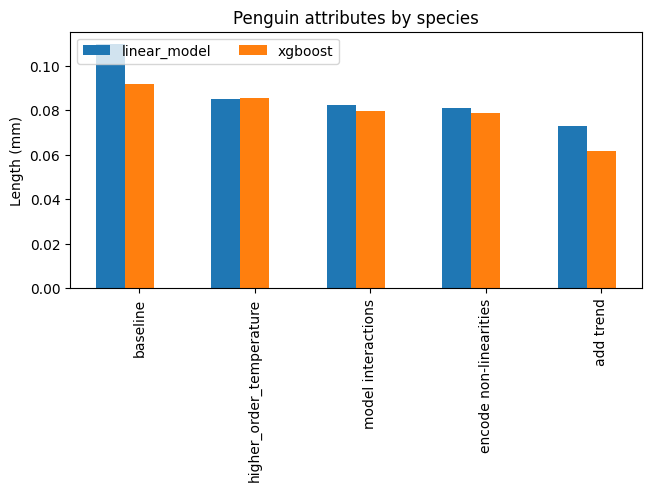

In [252]:
import matplotlib.pyplot as plt
import numpy as np

species = exp_s
penguin_means = models_scores

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for model_name, model_scores in penguin_means.items():
    scores = [model_score[1] for model_score in model_scores]
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=model_name)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [251]:
models_best = {}
for model_name in model_names:
    model_scores = models_scores[model_name]
    scores = [model_score[1] for model_score in model_scores]
    models = [model_score[0] for model_score in model_scores]
    best_score = np.min(scores)
    best_model = models[np.argmin(scores)]
    models_best[model_name] = (best_model, best_score)
models_best

{'linear_model': (Pipeline(steps=[('select_optimal_temperature_columns',
                   OptimalTemperatureSelector(optimal_temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/optimal_temperature_columns.pkl'),
                                              temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/temperature_col...
                  ('create_trend',
                   DerivedColumnTransformer(column_name='datetime',
                                            derive_func=<function trend at 0x7f21d65bc0d0>,
                                            new_column_name='trend')),
                  ('one_hot_categorical_column',
                   ColumsOneHotEncoder(categorical_column_names=['hour',
                                                                 'month'])),
                  ('drop_columns',
                   ColumnsRemover(column_names=['date', 'hour

## Evaluation





transform


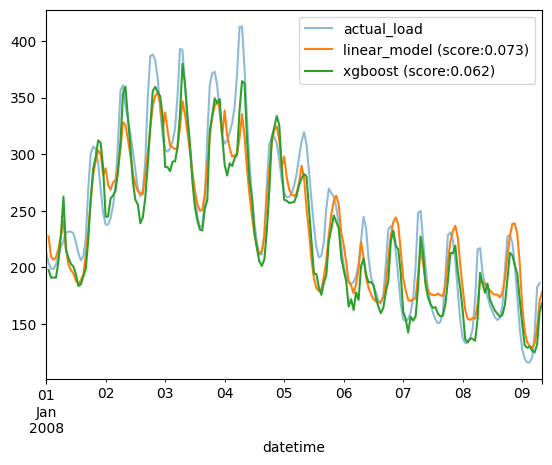

In [259]:
import pandas as pd
from src.preprocessing import preprocessing as prep
from src.inference import inference as inf
from src import utils

proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')



raw_temperature_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])
raw_temperature_data = pd.read_csv(raw_temperature_data_path, parse_dates=[0])
preprocessed_temperature_data = prep.TempDataPreprocessor().fit(raw_temperature_data).transform(raw_temperature_data)
inf_year = 2008
preprocessed_temperature_data = preprocessed_temperature_data[preprocessed_temperature_data.datetime.dt.year >= inf_year]
preprocessed_temperature_data = preprocessed_temperature_data.iloc[1:, :]  # includes first date not in eval
future_dates = preprocessed_temperature_data.datetime #+ p.to_timedelta(preprocessed_temperature_data.datetime.dt.hour, unit='h')



eval_data_path = config['data_paths']['evaluation_data']
actual_load = pd.read_csv(proj_root.joinpath(eval_data_path), parse_dates=[0])
actual_load = prep.LoadDataPreprocessor().fit(actual_load).transform(actual_load)

fig, ax = plt.subplots()
n_pts = 200
start = 0
actual_load[start:n_pts+start].plot(x='datetime', y='load', ax=ax, alpha=0.5, label="actual_load")
for i, model_name in enumerate(model_names):
    model, score = models_best[model_name]
    # model = inf.load_model(model_name=model_name)
    predicted_load = model.predict(preprocessed_temperature_data)

    prediction_data = pd.DataFrame({'datetime':future_dates, 'predicted_load':predicted_load})

    
    prediction_data[start:n_pts+start].plot(x='datetime', y='predicted_load', ls='-', ax=ax, alpha=1, label=f'{model_name} (score:{score:.3f})')